# The Football Lab: Predicting Player Impact by Position

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [130]:

raw_dataset_23 = pd.read_csv("datasets/2022-2023_Football_Player_Stats.csv", encoding="latin1")
raw_dataset_22 = pd.read_csv("datasets/2021-2022_Football_Player_Stats.csv", encoding="latin1")


## Cleaning & Structuring the Dataset

### Structuring the DataSet
Here in this section we're going to manipulate the dataset. The manipulation are made so it's easier to use it.     
Let's start adding a row with the name of all columns..

In [131]:
## Data Preprocessing
raw_dataset_22.loc[len(raw_dataset_22)] = raw_dataset_22.columns

raw_dataset_22 = raw_dataset_22.iloc[:,0].str.split(";", expand=True)
raw_dataset_22.columns =raw_dataset_22.iloc[len(raw_dataset_22)-1]

raw_dataset_22 = raw_dataset_22.drop(index =len(raw_dataset_22)-1)

raw_dataset_22.head()

#raw_dataset_22.columns

2921,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Max Aarons,ENG,DF,Norwich City,Premier League,22,2000,34,32,...,0.03,1.41,1.16,0,0.06,0.03,5.53,0.47,1.59,22.7
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,1987,34,34,...,0,0.06,1.39,0,0.03,0,6.77,2.02,1.36,59.8
2,3,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,2000,31,29,...,0,0.36,1.24,0,0,0,8.76,0.88,0.88,50
3,4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,1993,34,34,...,0.03,0.79,2.23,0,0,0,8.87,0.43,0.43,50
4,5,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,22,2000,1,1,...,0,2,0,0,0,0,4,2,0,100


In [132]:
## Data Preprocessing
raw_dataset_23.loc[len(raw_dataset_23)] = raw_dataset_23.columns

raw_dataset_23 = raw_dataset_23.iloc[:,0].str.split(";", expand=True)
raw_dataset_23.columns =raw_dataset_23.iloc[len(raw_dataset_23)-1]

raw_dataset_23 = raw_dataset_23.drop(index =len(raw_dataset_23)-1)

raw_dataset_23.head()

2689,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,2000,20,19,...,0.17,2.54,0.51,0,0,0,4.86,0.34,1.19,22.2
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,22,22,...,0.05,0.18,1.59,0,0,0,6.64,2.18,1.23,64
2,3,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,1999,14,8,...,0,1.05,1.4,0,0,0,8.14,0.93,1.05,47.1
3,4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,20,20,...,0,0.35,0.8,0,0,0.05,6.6,0.5,0.5,50
4,5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1993,15,15,...,0,0.23,2.02,0,0,0,6.51,0.31,0.39,44.4


Here we are going to delete all the non common columns between the two datasets and the duplicated row.

In [133]:
common_columns = raw_dataset_23.columns.intersection(raw_dataset_22.columns)

raw_dataset_22 = raw_dataset_22[common_columns]
raw_dataset_23 = raw_dataset_23[common_columns]

# Remove duplicates from the dataset
raw_dataset_22 = raw_dataset_22[~raw_dataset_22['Player'].duplicated(keep=False)]

# Remove Javier Llabrés from the datasets because the row in dataset 2021-2022 is incompleted
raw_dataset_22 = raw_dataset_22[raw_dataset_22['Player'] != 'Javier Llabrés']
raw_dataset_23 = raw_dataset_23[raw_dataset_23['Player'] != 'Javier Llabrés']
raw_dataset_22 = raw_dataset_22[raw_dataset_22['Pos'] != 'GKMF']


#### Creating the clear dataset
In this section we choose which columns of datasets that we want keep and which must be converted

In [134]:
columns_to_keep = ["Player", "Nation", "Pos", "Squad", "Comp", "Age", "Min", "MP", "SoT%", "PasTotCmp%", "Goals", "Assists", "TklWon" ,"Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdY", "CrdR", "Recov"]
columns_to_convert = ["Age", "Min", "MP", "SoT%", "PasTotCmp%", "Goals", "Assists", "TklWon" , "Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdY", "CrdR", "Recov"]

raw_dataset_22["Min"] = raw_dataset_22["Min"].apply(lambda col: pd.to_numeric(col, errors='coerce'))
raw_dataset_23["Min"] = raw_dataset_23["Min"].apply(lambda col: pd.to_numeric(col, errors='coerce'))

column_not_to_norm = ["Player", "Nation", "Pos", "Comp", "Age", "Min", "MP", "SoT%", "PasTotCmp%"]

dataset_22 = raw_dataset_22[columns_to_keep].copy()
dataset_23 = raw_dataset_23[columns_to_keep].copy()

for col in columns_to_convert:
    dataset_22[col] = dataset_22[col].apply(lambda col: pd.to_numeric(col, errors='coerce'))
    dataset_23[col] = dataset_23[col].apply(lambda col: pd.to_numeric(col, errors='coerce'))

for col in columns_to_convert:
    dataset_22.loc[:, col] = pd.to_numeric(dataset_22[col], errors='coerce')
    dataset_23.loc[:, col] = pd.to_numeric(dataset_23[col], errors='coerce')


#### Normalization
In this section we are going to normalize certain columns for the season.

In [135]:
columns_to_normalize = ["Goals", "Assists", "TklWon" ,"Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdR", "Recov"]

for index, line in dataset_22.iterrows():
    for column in columns_to_normalize:
        dataset_22.at[index, column] = round(dataset_22.at[index, column] * raw_dataset_22.at[index, "Min"] / 90, 0)

columns_to_normalize = [ "Assists", "TklWon" ,"Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdR", "Recov"]

for index, line in dataset_23.iterrows():
    for column in columns_to_normalize:
        dataset_23.at[index, column] = round(dataset_23.at[index, column] * raw_dataset_23.at[index, "Min"] / 90, 0)

dataset_22.head()

2921,Player,Nation,Pos,Squad,Comp,Age,Min,MP,SoT%,PasTotCmp%,...,TouDef3rd,AerWon,Err,Fls,PasLonCmp,PasLonAtt,PasDead,CrdY,CrdR,Recov
0,Max Aarons,ENG,DF,Norwich City,Premier League,22,2881,34,15.4,75.5,...,746.0,15.0,0.0,31.0,98.0,217.0,339.0,0.25,0.0,177.0
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,2983,34,33.3,82.4,...,1087.0,67.0,0.0,43.0,187.0,303.0,100.0,0.15,1.0,224.0
2,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,2462,31,27.8,91.7,...,621.0,24.0,0.0,45.0,184.0,214.0,20.0,0.44,3.0,240.0
3,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,2956,34,23.3,81.6,...,450.0,14.0,0.0,46.0,205.0,308.0,28.0,0.27,0.0,291.0
4,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,22,45,1,0.0,33.3,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,2.0


In [136]:
dataset_23.head()

2689,Player,Nation,Pos,Squad,Comp,Age,Min,MP,SoT%,PasTotCmp%,...,TouDef3rd,AerWon,Err,Fls,PasLonCmp,PasLonAtt,PasDead,CrdY,CrdR,Recov
0,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,1596,20,18.5,74.9,...,77.0,6.0,1.0,11.0,16.0,42.0,51.0,0.11,0.0,86.0
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1980,22,5.3,81.5,...,605.0,48.0,1.0,29.0,83.0,154.0,82.0,0.09,0.0,146.0
2,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,770,14,33.3,80.8,...,98.0,8.0,0.0,15.0,38.0,51.0,10.0,0.12,0.0,70.0
3,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,1799,20,25.0,91.6,...,240.0,10.0,0.0,49.0,67.0,86.0,28.0,0.15,0.0,132.0
4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1165,15,0.0,87.3,...,249.0,4.0,0.0,12.0,34.0,51.0,10.0,0.16,0.0,84.0


## Visualization
Here we are going to explore some of the data in our dataset such as ditribution of Minutes palyed, Assists served based on the Position of the player.

### Distribution of Minutes played

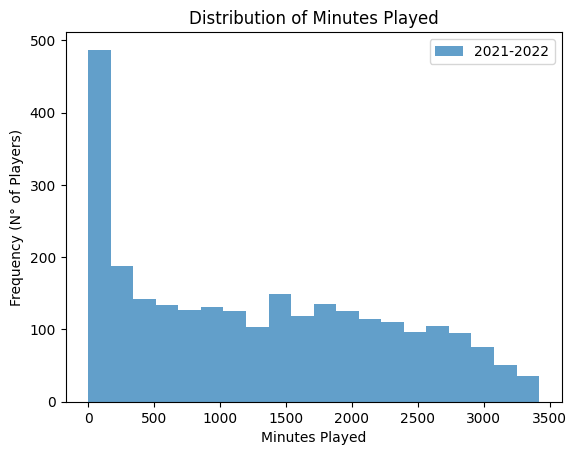

In [137]:
plt.hist(dataset_22["Min"], bins=20, alpha=0.7, label="2021-2022")
plt.xlabel("Minutes Played")
plt.ylabel("Frequency (N° of Players)")
plt.title("Distribution of Minutes Played")
plt.legend()
plt.show()

#### Observation:
The highest bar is located on the far left, close to zero. This indicates that a large number of players played a very low number of minutes during the season. This leads to the conclusion that these players are substitutes, debutants, or have suffered injuries. 
After that, a general decrease in the number of players is noticeable as the minutes played increase.

### Boxplot of the Minutes played by each player based on Position

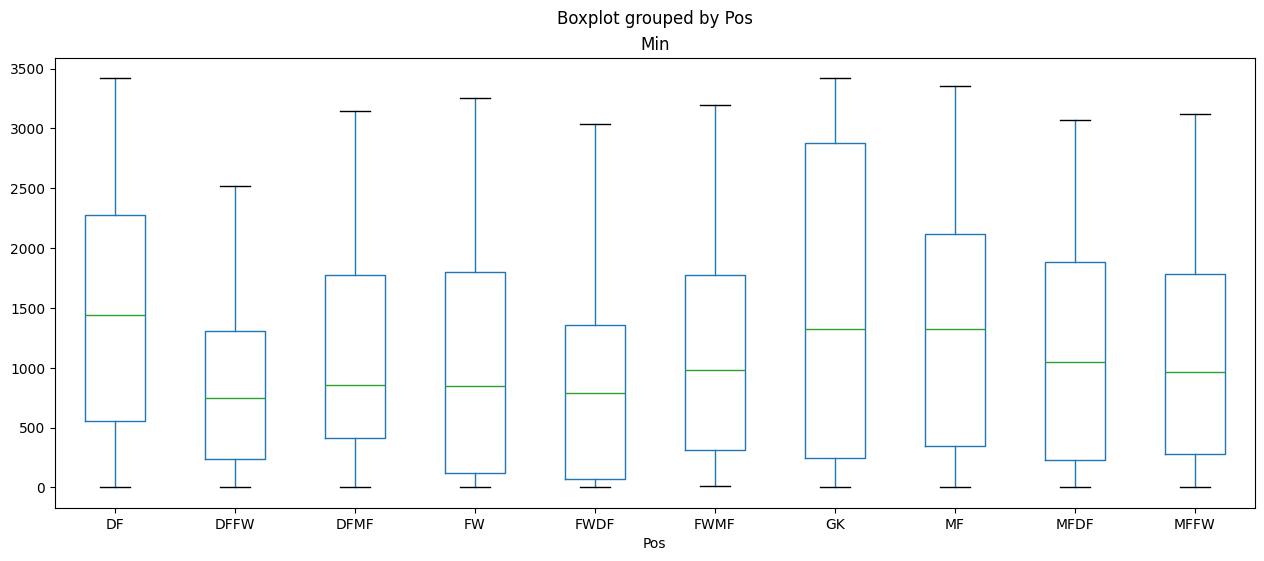

In [138]:
dataset_22.boxplot(column="Min", by="Pos", grid=False, figsize=(15, 6))
plt.show()

#### In the chart we observe that:       
The first thing to note is that there are no outliers in any positions.      
- __Goalkeepers__     
It's evident that the goalkeepers shows less variation compared with the other positions. This indicate that thay usually a goalkeeper play full match (90 minutes)         
- __Defenders__       
For them the graph shows that, unlike the goalkeepers, there is an higher variation, but they have the higher median of all positions.     
- __Forwards__        
As it's shows from the graph they are the positions wich played less minutes, this indicate that the are usually substituted or gets injured.     

### Boxplot of the number of Assists by each player based on Position

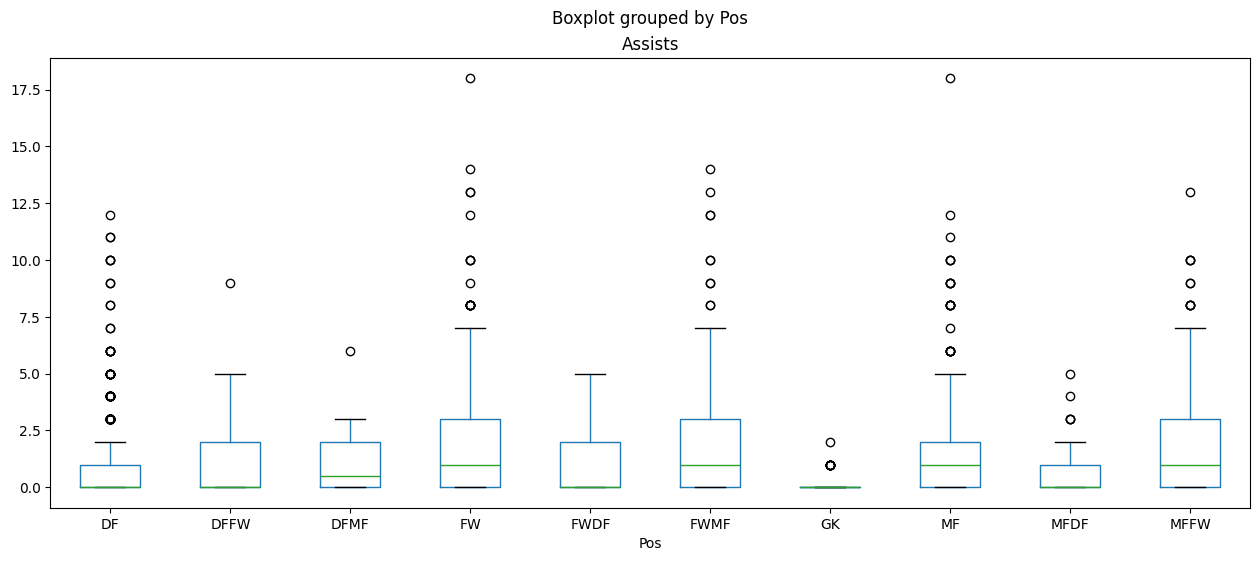

In [139]:
dataset_22.boxplot(column="Assists", by="Pos", grid=False, figsize=(15, 6))
plt.show()

#### In the chart we observe that:

- __Forwards__ (FW) are clearly the position with the highest number of goals scored; in fact, the median is the highest among all roles. Furthermore, for this role, there are very high outlier values, indicating some forwards with a number of goals significantly above the average.

- __Attacking midfielders__ and wingers (FWMF, FWDF, MFFW) tend to score more goals compared to defenders and central midfielders, as expected. Meanwhile, central midfielders and defensive midfielders (MF, MFDF) tend to score fewer goals, and the outliers are less frequent.

- __Defenders__ (DF), including those with more offensive duties (DFFW, DFMF), generally show the lowest number of goals scored; in fact, their medians are very low, close to zero, and the outliers, while present, naturally reach lower values compared to forwards and attacking midfielders.

- __Goalkeepers__ (GK), as expected, almost always score zero goals. A hypothetical outlier would suggest a very rare case of a goal scored by a goalkeeper.

## OLAP
Here in this section we're going to use an OLAP visualizations of the dataset.      
The OLAP cube'll have three dimentions (Assists, Age, Comp) 

In [140]:
dataset_22_OLAP = dataset_22.copy()

In this section we are going to quantize Comp, Age, Assists and Min


In [141]:
quantize_comp = ["Bundesliga", "La Liga", "Ligue 1", "Premier League", "Serie A"]

dataset_22_OLAP.loc[dataset_22_OLAP['Age'].between(16,21,'both'),'quantize_age'] = 'YOUNG'
dataset_22_OLAP.loc[dataset_22_OLAP['Age'].between(22,27,'both'),'quantize_age'] = 'PROMISE'
dataset_22_OLAP.loc[dataset_22_OLAP['Age'].between(28,33,'both'),'quantize_age'] = 'PRIME'
dataset_22_OLAP.loc[dataset_22_OLAP['Age'].between(34,41,'both'),'quantize_age'] = 'OLD'
quantize_age = ['YOUNG','PROMISE','PRIME','OLD']

dataset_22_OLAP.loc[dataset_22_OLAP['Assists'].between(0.0,4.9,'both'),'quantize_assists'] = 'NOTHING'
dataset_22_OLAP.loc[dataset_22_OLAP['Assists'].between(5.0,9.9,'both'),'quantize_assists'] = 'SOLID'
dataset_22_OLAP.loc[dataset_22_OLAP['Assists'].between(10.0,14.9,'both'),'quantize_assists'] = 'GOOD'
dataset_22_OLAP.loc[dataset_22_OLAP['Assists'].between(15.0,19.9,'both'),'quantize_assists'] = 'EXCELLENT'
quantize_assists = ['NOTHING','SOLID','GOOD','EXCELLENT']

dataset_22_OLAP.loc[dataset_22_OLAP['Min'].between(0,854,'both'),'quantize_min'] = 'BENCHER'
dataset_22_OLAP.loc[dataset_22_OLAP['Min'].between(855,1710,'both'),'quantize_min'] = 'SUB'
dataset_22_OLAP.loc[dataset_22_OLAP['Min'].between(1711,2566,'both'),'quantize_min'] = 'STARTER'
dataset_22_OLAP.loc[dataset_22_OLAP['Min'].between(2567,3420,'both'),'quantize_min'] = 'ESSENTIAL'
quantize_min = ['BENCHER','SUB','STARTER','ESSENTIAL']

### OLAP Min/Age/Comp visualizations

In [142]:
OLAP_min = np.zeros((4,4,5))
for z in range(0,len(quantize_comp)):
  Awards_prog_z = dataset_22_OLAP[dataset_22_OLAP['Comp'] == quantize_comp[z]]
  for j in range(0,len(quantize_age)):
    for i in range(0,len(quantize_min)):
      OLAP_min[i,j,z] = np.sum((Awards_prog_z['quantize_min'] == quantize_min[i]) & (Awards_prog_z['quantize_age'] == quantize_age[j]))

Here it's performed a slice through the Comp, more specifically Bundesliga, so the chart will show the frequencies of player divided by Minutes played and Age

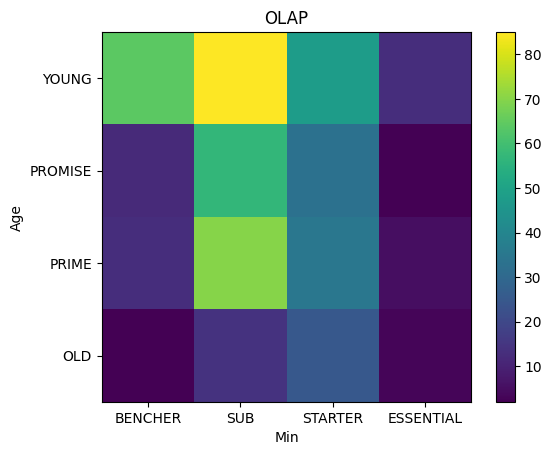

In [143]:
slice_comp = OLAP_min[:,:,0]

plt.ylabel('Age')
plt.xlabel('Min')
plt.imshow(slice_comp)
plt.yticks(ticks=range(len(quantize_age)), labels=quantize_age)
plt.xticks(ticks=range(len(quantize_min)), labels=quantize_min)
plt.colorbar()
plt.title('OLAP')
plt.show()

#### Observations:      
The graph above shows that usually the player are SUB wihic means that they played a lots of games but non for 90 minutes.      
The Yunger player are the most likely to be SUB but at the same time, in Bundesliga (Germania), there are more ESSENTIAL Young player compared to the other Age.        
The Old player aren't usually BENCHER or ESSENTIAL but they usually are SUB or STARTER.     
Another information in the graph is that in Bundesliga there are a lot of YOUNG player.

### OLAP Assists/Age/Comp visualizations

In [144]:
OLAP_assists = np.zeros((4,4,5))
for z in range(0,len(quantize_comp)):
  Awards_prog_z = dataset_22_OLAP[dataset_22_OLAP['Comp'] == quantize_comp[z]]
  for j in range(0,len(quantize_age)):
    for i in range(0,len(quantize_assists)):
      OLAP_assists[i,j,z] = np.sum((Awards_prog_z['quantize_assists'] == quantize_assists[i]) & (Awards_prog_z['quantize_age'] == quantize_age[j]))

We've decided to create another OLAP for explore the Assists in the different Comp. Here it's perfermed a slice on the Comp column (La Liga, Spagna) such that it's possible to show Age e Assists

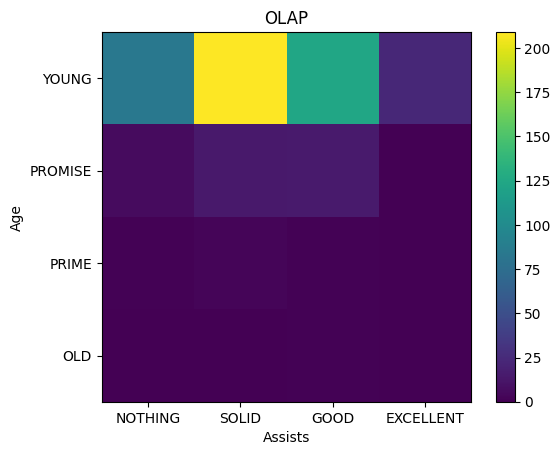

In [145]:
slice_comp = OLAP_assists[:,:,0]

plt.ylabel('Age')
plt.xlabel('Assists')
plt.imshow(slice_comp)
plt.yticks(ticks=range(len(quantize_age)), labels=quantize_age)
plt.xticks(ticks=range(len(quantize_assists)), labels=quantize_assists)
plt.colorbar()
plt.title('OLAP')
plt.show()

#### Observations:
The graph shows that, as we said before, most of the player that served an assists has got between 16 to 21 years of age. In specific as we can see the yellow square is in (YOUNG, SOLID) position which means that more tha 200 player between 16-21 served 5 to 9 assists.       
The OLAP visualization shows that in the other age it's more likely that the player didn't serve much assists.

## Statistical Tests

We need to verify some hypothesis such as:
1. Sample with number of elem n > 30;
2. Population N at least ten time bigger than the sample N > 10*n.

#### Assist mean comparison between Italy and German
The hypothesis are verified, so we can use a two-tailed t-test.

We’ll use a significance level of 0.05 (which means a 95% confidence level).

__Null hypothesis (H₀)__:   
The average number of assists in Serie A and the Bundesliga are not significantly different.

__Alternative hypothesis (Hₐ)__:    
The averages are different.

Significance level: 0.05

In [146]:
t_statistic, p_value = stats.ttest_1samp(a= dataset_22['Assists'][dataset_22['Comp']=='Bundesliga'], popmean= dataset_22['Assists'][dataset_22['Comp']=='Serie A'].mean())
print(p_value)
if p_value >= 0.05:
        print("Non possiamo rigettare l'ipotesi nulla")
elif p_value < 0.05:
    # per verificare l'ordine di grandezza
    if 0.05/p_value > 100:
        print("Le medie sono diverse, accetto l'ipotesi alternativa")
    else:
        print("Rigettiamo l'ipotesi nulla ma non possiamo accettare l'ipotesi alternativa")

0.07929207467328196
Non possiamo rigettare l'ipotesi nulla


The t-test didn't show a statistically significant difference between the two means. So, there is no evidence that the two means are different.

We’ll use a significance level of 0.05 (which means a 95% confidence level).

__Null hypothesis (H₀)__:   
The average number of goals in Serie A is lower than the average number of goals in the Bundesliga.

__Alternative hypothesis (Hₐ)__:    
The average number of goals in Serie A is not lower than the average number of goals in the Bundesliga.

Significance level: 0.05

In [147]:
# ttest ind da usare perché indipendenti
t_statistic, p_value = stats.ttest_1samp(a= dataset_22['Assists'][dataset_22['Comp']=='Bundesliga'], popmean= dataset_22['Assists'][dataset_22['Comp']=='Serie A'].mean(), alternative= 'less')
print(p_value)
if p_value >= 0.05:
        print("Non possiamo rigettare l'ipotesi nulla")
elif p_value < 0.05:
    if 0.05/p_value > 100:
        print("Le medie sono diverse, accetto l'ipotesi alternativa")
    else:
        print("Rigettiamo l'ipotesi nulla ma non possiamo accettare l'ipotesi alternativa")

0.960353962663359
Non possiamo rigettare l'ipotesi nulla


#### Sanity check

In [148]:
t_statistic, p_value = stats.ttest_1samp(a= dataset_22['Assists'][dataset_22['Comp']=='Bundesliga'], popmean= dataset_22['Assists'][dataset_22['Comp']=='Serie A'].mean(), alternative= 'greater')
print(p_value)
if p_value >= 0.05:
        print("Non possiamo rigettare l'ipotesi nulla")
elif p_value < 0.05:
    if 0.05/p_value > 100:
        print("Le medie sono diverse, accetto l'ipotesi alternativa")
    else:
        print("Rigettiamo l'ipotesi nulla ma non possiamo accettare l'ipotesi alternativa")

0.03964603733664098
Rigettiamo l'ipotesi nulla ma non possiamo accettare l'ipotesi alternativa


## Model training and test

Here we are going to train three different model, one for the __Strikers__, one for the __Midfileder__ and one for the __Defender__.

### Strikers

In [149]:
position = ['FW', 'FWMF', 'MFFW', 'FWDF']
strikers_data_train = dataset_22[dataset_22['Pos'].isin(position)]
strikers_data_test = dataset_23[dataset_23['Pos'].isin(position)]

features = ['Shots', 'SoT', 'SoT%', 'ShoDist', 'ShoPK', 'PasTotCmp', 'Assists', 'ScaSh', 'GCA', 'PKatt']
target = 'Goals'

X_train = strikers_data_train[features]
y_train = strikers_data_train[target]

X_test = strikers_data_test[features]
y_test = strikers_data_test[target]

striker_pridction = LinearRegression()
striker_pridction.fit(X_train, y_train)

y_pred = striker_pridction.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)

In [150]:
comparison_df = strikers_data_test[['Player', 'Goals']].copy()
comparison_df['Predicted Goals'] = y_pred_rounded

player_name = "Lionel Messi"
player_comparison = comparison_df[comparison_df['Player'] == player_name]
print(player_comparison)

2689        Player  Goals  Predicted Goals
1650  Lionel Messi     10               14


In [151]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.5310536295654753


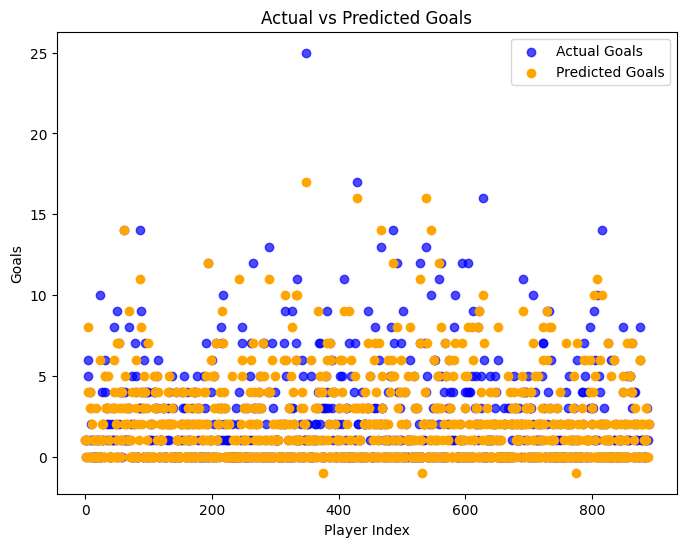

In [152]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Goals', alpha=0.7)

plt.scatter(range(len(y_pred_rounded)), y_pred_rounded, color='orange', label='Predicted Goals')

plt.xlabel('Player Index')
plt.ylabel('Goals')
plt.title('Actual vs Predicted Goals')
plt.legend()
plt.show()

### Midfielders

In [153]:
position = ['MF', 'MFDF', 'DFMF', 'MFFW', 'FWMF']
midfielders_data_train = dataset_22[dataset_22['Pos'].isin(position)]
midfielders_data_test = dataset_23[dataset_23['Pos'].isin(position)]

features = ['PasTotCmp', 'PasTotDist', 'PasAss', 'CrsPA', 'ScaPassLive', 'GCA', 'Carries', 'CarPrgDist', 'PPA']
target = 'Assists'

X_train = midfielders_data_train[features]
y_train = midfielders_data_train[target]

X_test = midfielders_data_test[features]
y_test = midfielders_data_test[target]

midfielder_pridction = LinearRegression()
midfielder_pridction.fit(X_train, y_train)

y_pred = midfielder_pridction.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)

In [154]:
comparison_df = midfielders_data_test[['Player', 'Assists']].copy()
comparison_df['Predicted Assists'] = y_pred_rounded

player_name = "Lionel Messi"
player_comparison = comparison_df[comparison_df['Player'] == player_name]
print(player_comparison)

2689        Player  Assists  Predicted Assists
1650  Lionel Messi     10.0                 10


In [155]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.6142102484976633


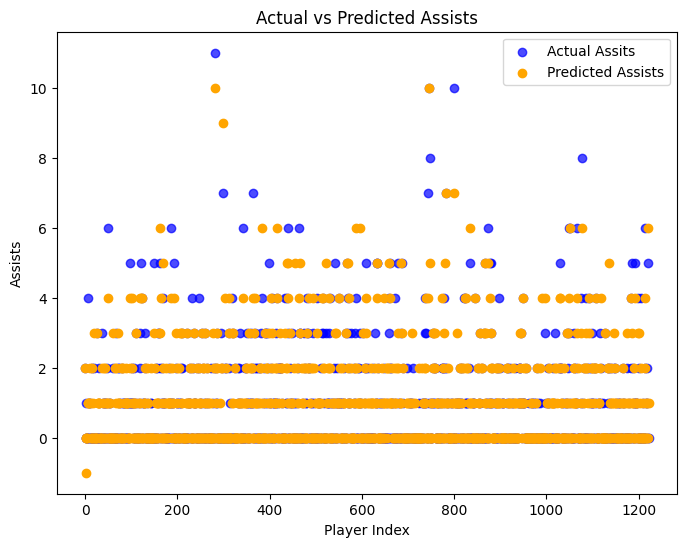

In [156]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Assits', alpha=0.7)

plt.scatter(range(len(y_pred_rounded)), y_pred_rounded, color='orange', label='Predicted Assists')

plt.xlabel('Player Index')
plt.ylabel('Assists')
plt.title('Actual vs Predicted Assists')
plt.legend()
plt.show()

### Defenders

In [157]:
position = ['DF', 'DFFW', 'DFMF']
defenders_data_train = dataset_22[dataset_22['Pos'].isin(position)]
defenders_data_test = dataset_23[dataset_23['Pos'].isin(position)]

features = ['Tkl', 'Recov', 'Int', 'Clr', 'AerWon', 'Fls']
target = 'TklWon'

X_train = defenders_data_train[features]
y_train = defenders_data_train[target]

X_test = defenders_data_test[features]
y_test = defenders_data_test[target]

defender_pridction = LinearRegression()
defender_pridction.fit(X_train, y_train)

y_pred = defender_pridction.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)

In [158]:
comparison_df = defenders_data_test[['Player', 'TklWon']].copy()
comparison_df['Predicted TklWon'] = y_pred_rounded

player_name = "Federico Dimarco"  
player_comparison = comparison_df[comparison_df['Player'] == player_name]
print(player_comparison)

2689            Player  TklWon  Predicted TklWon
688   Federico Dimarco    16.0                12


In [159]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 4.143662754851927


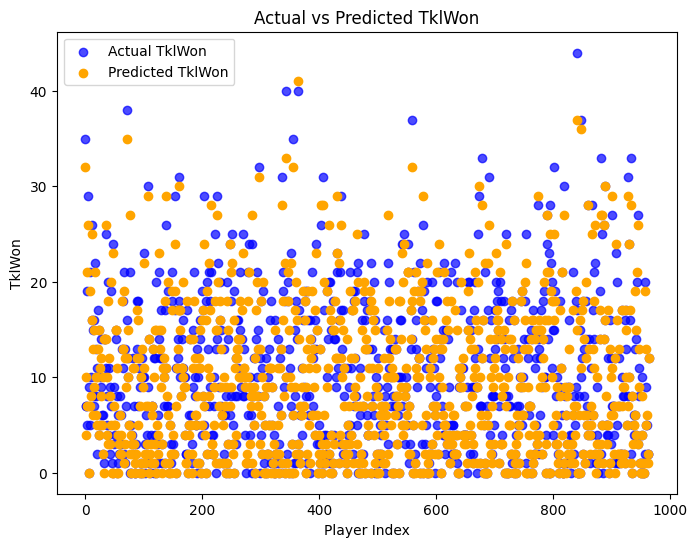

In [160]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual TklWon', alpha=0.7)

plt.scatter(range(len(y_pred_rounded)), y_pred_rounded, color='orange', label='Predicted TklWon')

plt.xlabel('Player Index')
plt.ylabel('TklWon')
plt.title('Actual vs Predicted TklWon')
plt.legend()
plt.show()